# s-HARM - One-dimensional example

This example gives the numerical implementation of the series HARM model.

For background, see: Houlsby et al. (2017) A model for nonlinear hysteretic and ratcheting behaviour. _International Journal of Solids and Structures_ __120__ 67-80.

The Gibbs free energy $g$ and the yield functions $y_n$ for this model are given by:

\begin{align*}
g = & -\frac{1}{2E} \sigma^2 - \sigma \left( \sum_{n=1}^N \alpha_n + \alpha_r \right) + \frac{1}{2} \sum_{n=1}^N H_n \alpha_n^2\\
y_n = & \left| \chi_n \right|  - k_n + R_n \left( |\chi_r| - |\sigma| \right)
\end{align*}

The constraint function links the ratcheting strain with the strain in each of the slider elements:

\begin{equation*}
c_r = \dot{\alpha}_r - S(\sigma) \sum_{n=1}^N R_n |\dot{\alpha}_n| = 0
\end{equation*}

The incremental response for this model can be written as follows (with$\frac{\partial^2 g}{\partial \alpha_n \partial \alpha_m}=0$ for $m \neq n$):

\begin{align*}
-\dot{\epsilon} = & \frac{\partial^2 g}{\partial \sigma^2} \dot{\sigma} + \sum_{n=1}^N \frac{\partial^2 g}{\partial \sigma \partial \alpha}_n \dot{\alpha}_n + \frac{\partial^2 g}{\partial \sigma \partial \alpha}_r \dot{\alpha}_r \\
-\dot{\bar{\chi}}_n = & \frac{\partial^2 g}{\partial \sigma \partial \alpha_n} \dot{\sigma} +  \frac{\partial^2 g}{\partial \alpha_n^2} \dot{\alpha}_n \\ 
-\dot{\bar{\chi}}_r = & \frac{\partial^2 g}{\partial \sigma \partial \alpha_r} \dot{\sigma} 
\end{align*}


The rate of hardening strain is defined by:

\begin{equation*}
\dot{\alpha}_n = \lambda_n \frac{\partial y_n}{\partial \chi}
\end{equation*}

where the multiplyer $\lambda_n$ is derived from the consistency condition:
\begin{equation*}
\dot{y}_n = 0 = \frac{\partial y_n}{\partial \sigma} \dot{\sigma} + \sum_{m=1}^N \frac{\partial y_n}{\partial \chi_m} \dot{\chi_m} + \frac{\partial y_n}{\partial \chi_r} \dot{\chi_r} + \sum_{m=1}^N \frac{\partial y_n}{\partial \alpha_m} \dot{\alpha_m} + \frac{\partial y_n}{\partial \alpha_r} \dot{\alpha_r} 
\end{equation*}

Combining the above equations for the one dimensional model with Ziegler's orthogonality condition ($\chi_n=\bar{\chi}_n$), and substituting $\frac{\partial y_n}{\partial \chi_m}=0$ for $m \neq n$, gives:
\begin{align*}
0 = & \frac{\partial y_n}{\partial \sigma} \dot{\sigma} - \frac{\partial y_n}{\partial \chi_n} \left( \frac{\partial^2 g}{\partial \sigma \partial \alpha_n} \dot{\sigma} + \frac{\partial^2 g}{\partial \alpha_n^2} \lambda \frac{\partial y_n}{\partial \chi_n} \right) - \frac{\partial y_n}{\partial \chi_r} \frac{\partial^2 g}{\partial \sigma \partial \alpha_r} \dot{\sigma} \\
\lambda_n = & \frac{\frac{\partial y_n}{\partial \sigma} - \frac{\partial y_n}{\partial \chi_n} \frac{\partial^2 g}{\partial \sigma \partial \alpha_n} - \frac{\partial y_n}{\partial \chi_r} \frac{\partial^2 g}{\partial \sigma \partial \alpha_r} }{\frac{\partial y_n}{\partial \chi_n} \frac{\partial^2 g}{\partial \alpha_n^2} \frac{\partial y_n}{\partial \chi_n}} \dot{\sigma}
\end{align*}

In [1]:
# The implementation of the above equations is given below
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Model parameters
E = 10
H_n = np.array([  8,   6,   4,   2,  1])
k_n = np.array([0.2, 0.4, 0.6, 0.8,  1])
R_n = np.array([0.1, 0.1, 0.1, 0.1, 0.1])
N = len(H_n)

# Initialise the model state parameters
epsilon = 0
chi_n = np.zeros(N)
chi_r = 0
alpha_n = np.zeros(N)
alpha_r = 0

# Define the applied stress history
sigma_max_abs_1 = 0.9
sigma_max_abs_2 = 0

d_sigma_abs = 0.001

sigma_loop = np.append(np.arange(0, sigma_max_abs_1, d_sigma_abs), 
                np.arange(sigma_max_abs_1, -sigma_max_abs_2, -d_sigma_abs))

sigma_history = np.tile(sigma_loop, 10)
epsilon_history = np.zeros(len(sigma_history))

d2_g_d_s2 = -1/E
d2_g_d_an2 =  H_n
d2_g_d_san = -np.ones(N)
d2_g_d_ans = -np.ones(N)
d2_g_d_sar = -1
d2_g_d_ars = -1

sigma_0 = 0

# Calculate the incremental response
for index, sigma in enumerate(sigma_history):
    
    d_sigma = sigma - sigma_0
        
    y_n = np.abs(chi_n) - k_n + R_n * (np.abs(chi_r) - np.abs(sigma))
    d_y_n_d_chi_n = np.sign(chi_n)
    d_y_n_d_chi_r =   R_n * np.sign(chi_r)
    d_y_n_d_sigma = - R_n * np.sign(sigma)
        
    lambda_n = (d_y_n_d_sigma - d_y_n_d_chi_n * d2_g_d_san - d_y_n_d_chi_r * d2_g_d_sar)/(d_y_n_d_chi_n * d2_g_d_an2 * d_y_n_d_chi_n) * d_sigma 
    lambda_n[lambda_n < 0] = 0
    lambda_n[y_n < 0] = 0
                
    d_alpha_n = lambda_n * d_y_n_d_chi_n
    d_alpha_r = np.sign(sigma) * np.sum(R_n * np.abs(d_alpha_n))
        
    d_epsilon = - (d2_g_d_s2 * d_sigma + np.sum(d2_g_d_san * d_alpha_n) + d2_g_d_sar * d_alpha_r )
    d_chi_n = - (d2_g_d_ans * d_sigma + d2_g_d_an2 * d_alpha_n)
    d_chi_r = - d2_g_d_ars * d_sigma
        
    epsilon = epsilon + d_epsilon
    chi_n = chi_n + d_chi_n
    chi_r = chi_r + d_chi_r
    alpha_n = alpha_n + d_alpha_n
    alpha_r = alpha_r + d_alpha_r
    
    sigma_0 = sigma
            
    epsilon_history[index] = epsilon   

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide


Text(0,0.5,'$\\sigma$')

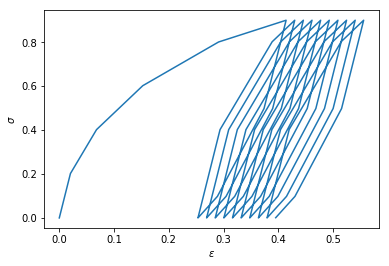

In [2]:
plt.plot(epsilon_history, sigma_history)
plt.xlabel('$\epsilon$')
plt.ylabel('$\sigma$')